Stochastic Variational Bayes
=======================

This notebook implements Example 1 from the FMRIB tutorial on Variational Bayes II: Stochastic Variational Bayes ("fitting a Gaussian distribution).

We assume we have data drawn from a Gaussian distribution with true mean $\mu$ and true precision $\beta$:

$$
P(y_n | \mu, \beta) = \frac{\sqrt{\beta}}{\sqrt{2\pi}} \exp{-\frac{\beta}{2} (y_n - \mu)^2}
$$

One interpretation of this is that our data consists of repeated measurements of a fixed value ($\mu$) combined with Gaussian noise with standard deviation $\frac{1}{\sqrt{\beta}}$.

Here's how we can generate some sample data from this model in Python:

In [1]:
import numpy as np
%matplotlib inline

# Ground truth parameters
# We infer the precision, BETA, but it is useful to
# derive the variance and standard deviation from it
MU_TRUTH = 42
BETA_TRUTH = 1.0
VAR_TRUTH = 1/BETA_TRUTH
STD_TRUTH = np.sqrt(VAR_TRUTH)

# Observed data samples are generated by Numpy from the ground truth
# Gaussian distribution. Reducing the number of samples should make
# the inference less 'confident' - i.e. the output variances for
# MU and BETA will increase
N = 100
DATA = np.random.normal(MU_TRUTH, STD_TRUTH, [N])
print("Data samples are:")
print(DATA)

Data samples are:
[40.99740869 40.40993049 42.17236502 41.44338713 42.08161293 42.19508147
 41.82557488 41.66429405 41.6937451  41.17965645 41.69820186 41.82553611
 41.05333475 42.87385341 40.94746534 40.11866728 43.37747551 44.71823618
 42.39012226 41.78182038 42.76540516 40.17920651 42.59959568 42.61958139
 40.36653844 42.44772963 41.99231622 41.738396   42.26377547 41.94032224
 42.44233361 41.52525351 41.23264705 41.42212412 42.37829121 41.87607231
 41.71758696 41.75841825 42.38544827 40.83822285 42.60609288 42.51866407
 42.32336891 39.45950693 42.21067759 41.82402653 41.35813614 42.3899432
 39.9039059  41.59166576 41.46107423 42.50740955 41.94432632 43.14863648
 42.00438395 43.64975295 42.01876202 42.53265461 41.93407702 42.60592961
 40.23010074 43.71195944 44.31706405 40.90335594 42.45106559 41.52144128
 40.59114134 42.3617661  43.00286889 43.81742771 42.12261727 40.80558308
 42.20627737 41.00026612 42.74285661 43.42798467 42.987332   43.0953204
 40.66967635 41.8029288  43.9587240

In the 'signal + noise' interpretation we can view this as noisy measurements (red crosses) of a constant signal (green line):

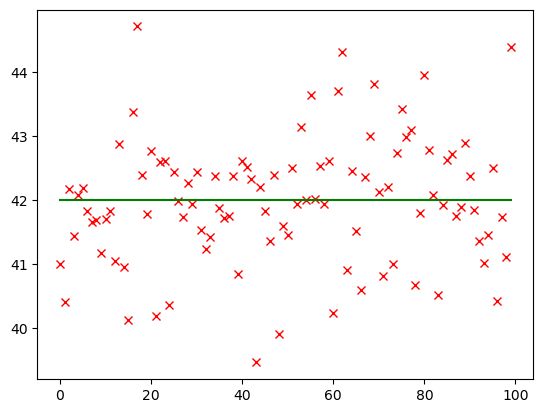

In [2]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(DATA, "rx")
plt.plot([MU_TRUTH] * N, "g")

In [3]:
m0 = 0.0
v0 = 10000.0
b0 = 0.0
w0 = 10000.0
print("Priors: P(mu, log(1/beta)) = MVN([%f, %f], [[%f, 0], [0, %f]])" % (m0, v0, b0, w0))

Priors: P(mu, log(1/beta)) = MVN([0.000000, 10000.000000], [[0.000000, 0], [0, 10000.000000]])


As with analytic Variational Bayes, we need to choose an approximate form for our priors and posteriors. However we have more freedom in the stochastic method since we are not limited by the requirement that the distributions be conjugate with respect to the likelihood. 

We will choose a multivariate normal distribution (MVN) over the two parameters $\mu$ and $log(\frac{1}{\beta})$ for prior and posterior. Inferring the log of the noise variance is useful as it avoid the possibility of negative values during the optimization which would make the likelihood ill-defined.

The choice of an MVN means that we can allow for covariance (correlation) between the noise and signal parameters. This is unlike the analytic case where the posterior had to be factorised over these two parameters.

An MVN distribution for $N$ parameters is defined by a vector of $N$ mean values and an $N \times N$ covariance matrix. For the prior we will use the following values:

$$\textbf{m}_0 = \begin{bmatrix} \mu_0 \\ b_0 \end{bmatrix}$$

$$\textbf{C}_0 = \begin{bmatrix} v_0 & 0 \\ 0 & w_0 \end{bmatrix}$$

Note that we are not assuming any prior covariance. 

We define some suitable relatively uninformative prior values here:

Stochastic VB is based around minimising the free energy so we will need to implement the calculation of the free energy. We will be using the TensorFlow framework to perform the minimisation so the calculation must be in terms of tensors (multidimensional arrays). In our case the following constant tensors must be defined (where $N$ is the number of data values we have:

 - Data samples: $[N]$
 - Prior mean: $[2]$
 - Prior covariance: $[2 \times 2]$

We must also define *variable* tensors for the posterior - TensorFlow will allow these to change during the optimization in order to minimise the cost (free energy):

 - Posterior mean: $[2]$
 - Posterior covariance: $[2 \times 2]$

The posterior covariance must be a positive-definite matrix - since the optimizer does not know this, it is possible that invalid values may arise and the optimization will fail. To get around this restriction we build the covariance matrix from its Chlolesky decomposition.

$$\textbf{C} = (\textbf{C}_{chol})^T\textbf{C}_{chol}$$

$\textbf{C}_{chol}$ must have positive diagonal elements, so we define the underlying variables for these elements in terms of the log and then form the full $\textbf{C}_{chol}$ matrix as a sum of the exponentials of the log-diagonal elements, and independent variables for the off-diagonal components.

The code for this is below. Note that we need to define initial values for the posterior variables. It turns out that in the stochastic method it is important that the initial poster variance is not too large so although the prior is not informative, the initial posterior is. 

The next requirement is to be able to obtain a sample of *predicted* data values from the posterior. In stochastic VB this is used to approximate the integrals in the calculation of the free energy. It is *not* related to the number of data samples we have. Smaller values give quicker calculation, but may result in a noisy, non-convergent optimization. We'll start off with a sample size of 5, but you can change this later if you want.

Note the use of the 'reparameterization trick' to express the samples as the scaling of a fixed MVN distribution - this improves the ability of the optimizer to choose better values for the next iteration.

Next we need to implement the free energy calculation. This is the sum of the reconstruction loss (the extent to which the posterior matches the data) and the latent loss (the extent to which the posterior matches the prior). Let's do the reconstruction loss first which is the expected value of the log-likelihood across the posterior distribution. Remember that the expectation integral is being approximated using the samples we have from the posterior. So we evaluate the log-likelihood for *each* set of samples and then take the mean across all the samples.

On to the latent loss, this is the log-KL divergence between the posterior and prior. Since
both our prior and posterior are MVN distributions, we can use a known analytic result as
given in the tutorial:

$\log P(y|\mu,\beta)=\frac n2\log\left(\frac{\beta}{2\pi}\right)-\frac{\beta}2\sum(y_i-\mu)^2$, log-KL=$\frac12\left(Tr(C_0^{-1}C)-\log\left(\frac{|C|}{|C_0|}\right)-N+(m-m_0)^TC_0^{-1}(m-m_0)\right)$


In [4]:
import tensorflow as tf

data = tf.constant(DATA, dtype=tf.float32)
prior_means = tf.constant([m0, v0], dtype=tf.float32)
prior_covariance = tf.constant([[v0, 0.0], [0.0, w0]], dtype=tf.float32)

chol_off_diag = tf.Variable([[0, 0], [0, 0]], dtype=tf.float32) ###variable

post_means_init = [0.0, 0.0]
post_covariance_init = [[1.0, 0.0], [0.0, 1.0]]

chol_log_diag = tf.Variable(tf.math.log(tf.linalg.diag_part(post_covariance_init)), dtype=tf.float32) ###variable

post_means = tf.Variable(post_means_init, dtype=tf.float32)



def cost_fun():
    N=100 #number of observations
    S=5 #number of samples from posterior
    
    # Comment in this line if you do NOT want to infer parameter covariances
    #chol_off_diag = tf.constant([[0, 0], [0, 0]], dtype=tf.float32)

    chol_diag = tf.linalg.diag(tf.math.sqrt(tf.math.exp(chol_log_diag)))
    post_covariance_chol = tf.math.add(chol_diag, tf.linalg.band_part(chol_off_diag, -1, 0))

    post_covariance = tf.matmul(tf.transpose(post_covariance_chol), post_covariance_chol) 

    eps = tf.random.normal((2, S), 0, 1, dtype=tf.float32)
    
    # Start off each sample with the current posterior mean
    # post_samples is now a tensor of shape [2, n_samples]
    
    samples = tf.tile(tf.reshape(post_means, [2, 1]), [1, S])

    # Now add the random sample scaled by the covariance
    post_samples = tf.add(samples, tf.matmul(post_covariance_chol, eps)) 

    mu_samples = post_samples[0]

    # Get the current estimate of the noise variance remembering that
    # we are inferring the log of the noise precision, beta

    log_noise_var = -post_samples[1]
    noise_var = tf.math.exp(log_noise_var)

    # Each sample value predicts the full set of values in the data sample.
    # For our constant-signal model, the prediction is simply a set of 
    # constant values. The prediction tensor will have shape [S, N]
    # where S is the sample size and N is the number of data values

    prediction = tf.tile(tf.reshape(mu_samples, [S, 1]), [1, N])
    
    # To calculate the likelihood we need the sum of the squared difference between the data  
    # and the prediction. This gives a value for each posterior sample so has shape [S]
    #    print(data.shape, prediction.shape)
    
    sum_square_diff = tf.reduce_sum(tf.math.square(data - prediction), axis=-1)
    
    # Now we calculate the likelihood for each posterior sample (shape [S])
    # Note that we are ignoring constant factors such as 2*PI here as they 
    # are just an fixed offset and do not affect the optimization 
    log_likelihood = 0.5 * (-log_noise_var * tf.cast(N,dtype=tf.float32) - sum_square_diff / noise_var)

    # Finally to evaluate the expectation value we take the mean across all the posterior
    # samples
    reconstr_loss = -tf.reduce_mean(log_likelihood)

    C = post_covariance
    C0 = prior_covariance

    m_minus_m0 = tf.reshape(tf.subtract(post_means, prior_means), [-1, 1])
    m_minus_m0_T = tf.reshape(tf.subtract(post_means, prior_means), [1, -1])

    C0_inv = tf.linalg.inv(C0)

    term1 = tf.linalg.trace(tf.matmul(C0_inv, C))
    term2 = -tf.math.log(tf.linalg.det(C) / tf.linalg.det(C0))

    # Size of the MVN distribution
    
    term3 = -2
    term4 = tf.matmul(tf.matmul(m_minus_m0_T, C0_inv), m_minus_m0)
    latent_loss = 0.5 * (term1 + term2 + term3 + term4)


    cost=reconstr_loss + latent_loss

    return cost


    
    



2024-02-28 18:33:22.859115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14789 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:01:00.0, compute capability: 7.0


To optimize the posterior we need to iteratively minimise the cost using TensorFlow's built in gradient optimizer. We use the Adam optimizer for this, which is a refinement of the standard Gradient Descent optimizer. 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
#minimizer = optimizer.minimize(cost)
#sess.run(tf.global_variables_initializer())
from tqdm.notebook import tqdm_notebook

cost_history = []
for epoch in tqdm_notebook(range(4000), desc="Epoch:"):
    #sess.run(minimizer)

    #cost_history.append(float(sess.run(cost)))
    optimizer.minimize(cost_fun,var_list=[chol_off_diag,chol_log_diag,post_means])
    #print(float(cost_fun()))
    cost_history.append(float(cost_fun()))
    #print("Epoch %i: posterior means=%s" % (epoch+1, post_means))

Epoch::   0%|          | 0/4000 [00:00<?, ?it/s]

2024-02-28 18:33:54.268204: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7bf45c0
2024-02-28 18:33:54.393652: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x58c40f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 18:33:54.393690: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-02-28 18:33:54.399550: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-28 18:33:54.619847: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


We should find our estimates for mu and beta are as expected, remembering that we chose
to estimate $-\log{\beta}$:

In [33]:
final_means = post_means
chol_diag = tf.linalg.diag(tf.math.sqrt(tf.math.exp(chol_log_diag)))
post_covariance_chol = tf.math.add(chol_diag, tf.linalg.band_part(chol_off_diag, -1, 0))
post_covariance = tf.matmul(tf.transpose(post_covariance_chol), post_covariance_chol) 
final_covariance = post_covariance
print("Estimate for mu: %f (variance: %f)" % (final_means[0], final_covariance[0, 0]))
print("Estimate for beta: %f" % np.exp(final_means[1]))

Estimate for mu: 42.030685 (variance: 0.026726)
Estimate for beta: 1.004724


The convergence of the minimisation in this case is rather slow - considering the simplicity of the problem. This is partly due to the large difference between the initial posterior and the true value for $\mu$. However, frameworks like TensorFlow are not really optimized for inferring such a small number of parameters and the method. If we plot the cost history we can see that it gets stuck in a local minimum for some time:

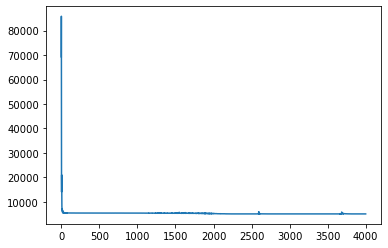

In [34]:
plt.plot(cost_history)
#plt.ylim(50000, 51000)

We can also plot our inferred value of $\mu$ with error bars $\pm 2\sigma$ derived from the inferred variance on this parameter

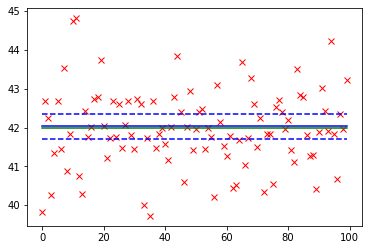

In [35]:
plt.figure()
plt.plot(DATA, "rx")
plt.plot([MU_TRUTH] * N, "g")
plt.plot([final_means[0]] * N, "b")
plt.plot([final_means[0]+2*np.sqrt(final_covariance[0, 0])] * N, "b--")
plt.plot([final_means[0]-2*np.sqrt(final_covariance[0, 0])] * N, "b--")

The main advantage of the SVB approach is the flexibility - as well as losing the restriction to conjugate priors, it is also much easier to implement more advanced types of parameters and priors, for example global parameters or spatial regularization priors. While these can (and have been) incorporated into the analytic VB framework, they require update equations to be re-derived whereas the SVB method simply needs an expression for the cost which is generally more straightforward.

Some things you might like to try with this example:

 - Do not infer the covariance between the parameters (see commented out code in the definition of the posterior). This generally makes the convergence less noisy.
 - Modify the number of samples and the learning rate and see how they affect the convergence
 - Try implementing the stochastic form of the latent loss rather than the analytic result for an MVN that we have used here (see Box 1 in the tutorial). This is necessary in cases where we do not assume an MVN structure for the prior and posterior. Essentially you need to calculate the log PDF for the prior and posterior for each sample and take the mean over all the samples.
 
